# COVID_Detection

## Objectives 
- Visualize the dataset
- Create data generators for the Normal and COVID datasets
- Train a CNN to detect COVID
    - Consider using an architecture like VGG16
    
- Stretch Goals
    - Create a GUI that allows you to:
        - Drag part of a screen to screenshot a potential XR
        - Show off a heatmap of the regions that indicated covid via heatmap
        - Show off the architecture of the model and show which parts are highlighted
        - Allow the model to be importable/replacable via joblib
        
        

## Part 1: Visualizing and Preprocessing Data

- Create a function to visualize the XR
- Identify how you want to preprocess each image (number of layers? Dimensions?)

In [1]:
!gdown https://drive.google.com/u/0/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:08, 88.6MB/s]


In [2]:
!unzip /content/COVID-19_Radiography_Database.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: /content/COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: /content/COVID-19_Radiogr

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

import os
import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

from google.colab import drive
drive.mount('/content/drive/')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

DATA_PATH = "/content/"

Mounted at /content/drive/
Num GPUs Available:  1


In [4]:
def read_image(path):
    """
    Show matplotlib image of XR
    """
    arrays = cv2.imread(path)
    print(arrays.shape)
    plt.imshow(arrays)
    
def read_random_image(choice="COVID"):
    """
    Pick a random image from each class and show it
    """
    assert choice in ["COVID", "Normal"]
    path = DATA_PATH + "COVID-19_Radiography_Dataset/" + choice + "/"
    files = os.listdir(path)
    path += random.choice(files)
    print(path)
    read_image(path)

/content/COVID-19_Radiography_Dataset/COVID/COVID-3351.png
(299, 299, 3)


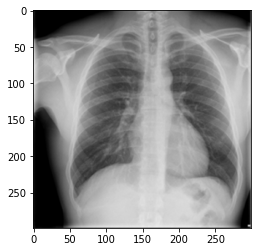

In [5]:
read_random_image()

/content/COVID-19_Radiography_Dataset/Normal/Normal-3824.png
(299, 299, 3)


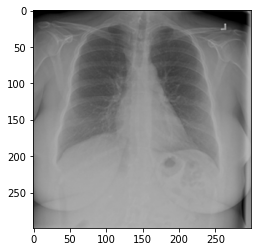

In [6]:
read_random_image("Normal")

## Image Preprocessing

These are X-Rays, which clearly only need to be in black and white. Looking at the arrays that are acquired from using cv2.imread() we get images in the shape of (299, 299, 3). We can reduce this to (299, 299, 1) by doing some simple preprocessing. This helps down the line as it reduces the amount of filters we need in the future.

Furthermore, we should normalize the data and change everything to range between 0 and 1, which helps in optimization down the line.

In [7]:
def preprocess_image(path):
    """
    1. Use imread and get the raw file in array format
    2. Use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to transform it to (299, 299)
    3. Divide entire array by 255 (Max pixel intensity)
    
    INPUTS:
        path --> String to file location
    OUTPUTS:
        final --> np.array of shape (299, 299)
    """
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final = gray / 255.0
    return final

## Dataset Building

Prior to building our model we need to ensure that the data is split into adequate ratios. Our dataset isn't presplit into Training and Validation folders (nor should it be) so we'll have to split it into train/validation/testing datasets without moving files around. We'll split the data using pandas and use a DataGenerator so we can incorporate preprocessing once the sample is called. Doing this also prevents us from saving a massive number of arrays into memory.

In [8]:
# Grab the image paths from each of the folders
# We don't know how many images are in each folder nor do we know how they're named. (e.g. COVID-1.png doesn't exist)
folders = {"COVID" : 1, "Normal" : 0}
BASE_PATH = DATA_PATH + "COVID-19_Radiography_Dataset/"
complete_filepaths = []
complete_labels = []

# Get a list of filepaths and labels
for folder, target in folders.items():
    full_path = BASE_PATH + folder + "/"
    
    # Get the image files
    files = os.listdir(full_path)
    files = [full_path + file for file in files]
    complete_filepaths += files
    
    # Get the labels
    labels = [target for file in files]
    complete_labels += labels

# Put these in a dataframe so we can split and shuffle them.
data = pd.DataFrame(list(zip(complete_filepaths, complete_labels)), columns=["path", "label"]).sample(frac=1)

In [9]:
# Examine the class imbalance
data['label'].value_counts()

0    10192
1     3616
Name: label, dtype: int64

In [10]:
# Remove the test data from the dataset completely
test = data.groupby("label", as_index=False).apply(lambda x:x.sample(frac=0.1)).reset_index()
test = test.reset_index().set_index('level_1').drop(columns=['level_0', 'index'])
test.index.name = ""

In [11]:
# Exclude the test data from train/val
train_and_val = data.drop(test.index, axis=0)

# Probably could have done the previous method with groupby but this is less of a headache
X_train, X_val, y_train, y_val = train_test_split(train_and_val['path'], train_and_val['label'], 
                                                 test_size=0.25, stratify=train_and_val['label'])
train = pd.DataFrame(list(zip(X_train, y_train)), columns=['path', 'label'])
val = pd.DataFrame(list(zip(X_val, y_val)), columns=['path', 'label'])

## Creating a Custom Generator

We can't use flow from directory so we'll have to make a generator. 

In [12]:
class MyDataGenerator(keras.utils.Sequence):
    """
    A Custom data generator so we can include whatever preprocessing steps we want.
    """
    
    def __init__(self, df, batch_size, shuffle):
        self.df = df.copy().reset_index(drop=True)
        self.X = df['path']
        self.y = df['label']
        self.batch_size = batch_size
        self.shuffle = shuffle 
        self.length = len(df)
        
    def __get_input(self, path):
        """
        Helper function for preprocessing
        """
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        arr = gray / 255.
        return np.expand_dims(arr, 2)
    
    def __get_output(self, label):
        """
        Transform singular label into keras accepted format
        """
        return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batch):
        """
        Transform batches into features and labels
        """
        X = batch['path']
        y = batch['label']
        X_batch = np.array([self.__get_input(path) for path in X])
        y_batch = np.array([self.__get_output(y_) for y_ in y])
        return X_batch, y_batch
    
    def __getitem__(self, index):
        """
        __getitem__ method for indexing used in training process itself
        """
        batch = self.df[index * self.batch_size:(index+1) * self.batch_size]
        X, y = self.__get_data(batch)
        return X, y
    
    def on_epoch_end(self):
        """
        Obviously we should shuffle the dataset at the end of each epoch
        """
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.length // self.batch_size

    def show_value_counts(self,normalize):
        print(self.df['label'].value_counts(normalize=normalize))
        
    def show_random_image(self):
        index = random.randint(1, self.length)
        path = self.df.loc[index, 'path']
        print(path)
        label = self.df.loc[index, 'label']
        arr = self.__get_input(path).reshape(299, 299)
        plt.imshow(arr, cmap='gray')
        print(f"Label: {label}. Dims: {arr.shape}")

In [13]:
# Turn these into Generators
train_gen = MyDataGenerator(train, 64, True)
val_gen = MyDataGenerator(val, 16, True)

/content/COVID-19_Radiography_Dataset/COVID/COVID-3536.png
Label: 1. Dims: (299, 299)


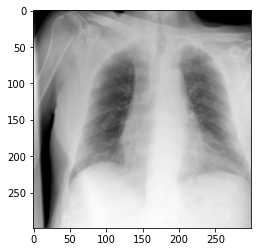

In [30]:
train_gen.show_random_image()

## Creating Our Model

There's no metadata regarding each patient so we can just use a sequential model.

In [36]:
def make_model():
    model = Sequential()
    model.add(Input(shape=(299,299,1)))
    model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(units=2, activation='sigmoid'))
    
    opt = SGD()
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics='accuracy')
    
    return model

model = make_model()

## Training Our Model

In [37]:
model.fit(train_gen, validation_data=val_gen,
         epochs=30)

Epoch 1/30
145/145 [==============================] - 103s 683ms/step - loss: 0.6565 - accuracy: 0.7022 - val_loss: 0.6225 - val_accuracy: 0.7374
Epoch 2/30
145/145 [==============================] - 98s 674ms/step - loss: 0.5062 - accuracy: 0.7334 - val_loss: 0.5964 - val_accuracy: 0.7381
Epoch 3/30
145/145 [==============================] - 98s 674ms/step - loss: 0.4582 - accuracy: 0.7364 - val_loss: 0.5771 - val_accuracy: 0.7378
Epoch 4/30
145/145 [==============================] - 98s 674ms/step - loss: 0.4260 - accuracy: 0.7345 - val_loss: 0.5102 - val_accuracy: 0.7374
Epoch 5/30
145/145 [==============================] - 98s 673ms/step - loss: 0.3874 - accuracy: 0.7348 - val_loss: 0.4092 - val_accuracy: 0.7381
Epoch 6/30
145/145 [==============================] - 98s 674ms/step - loss: 0.3680 - accuracy: 0.7364 - val_loss: 0.3333 - val_accuracy: 0.7384
Epoch 7/30
145/145 [==============================] - 98s 676ms/step - loss: 0.3502 - accuracy: 0.7377 - val_loss: 0.3054 - val_a

In [2]:
# Save this model to wherever you want it to 
def save_model(model, path):
    model.save(path + "/models/my_model")

save_model(model, MY_PATH)